In [1]:
# Import libraries we'll need
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import IncrementalPCA
import os


In [2]:
# Set the dataset path and image size
dataset_path = "fruits-360_100x100/fruits-360/Training"
img_size = (100, 100)
batch_size = 52  # Should be equal or more than n_components for PCA

# Create image generator and split into training and validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training images
train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    subset="training",
    class_mode="sparse",  # using sparse labels since we don't one-hot encode
    shuffle=False
)

# Load validation images
val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    subset="validation",
    class_mode="sparse",
    shuffle=False
)
# Get the number of classes and samples
num_classes = train_gen.num_classes
num_samples = train_gen.samples # Number of samples in the training set
print(f"Number of classes: {num_classes}")  

Found 69293 images belonging to 170 classes.
Found 17261 images belonging to 170 classes.
Number of classes: 170


In [3]:
# Create PCA object with 50 components
pca = IncrementalPCA(n_components=50)

# Go through all batches and fit PCA on training images
batch_count = len(train_gen)

for i in range(batch_count):
    batch_X, _ = next(train_gen)  # get batch images only
    batch_X = batch_X.reshape(batch_X.shape[0], -1)  # flatten the images
    pca.partial_fit(batch_X)  # update PCA with this batch
    print(f"Fitting PCA batch {i+1}/{batch_count}", end="\r")

# Now we can transform the training and validation images
        



In [4]:
import csv

# Function to save reduced PCA features to CSV
def save_batches_to_csv(generator, csv_file):
    with open(csv_file, "w", newline="") as file:
        writer = csv.writer(file)
        for i in range(len(generator)):
            batch_X, batch_y = next(generator)
            batch_X = batch_X.reshape(batch_X.shape[0], -1)
            batch_X_pca = pca.transform(batch_X)  # apply PCA
            for x, y in zip(batch_X_pca, batch_y):
                writer.writerow(np.append(x, y))  # save features + label
            print(f"Saved batch {i+1}/{len(generator)} to {csv_file}", end="\r")

# Save PCA-transformed features to CSV files
save_batches_to_csv(train_gen, "fruit_pca_train.csv")
save_batches_to_csv(val_gen, "fruit_pca_val.csv")


In [5]:
import pickle
with open("pca_transformer.pkl", "wb") as f:
    pickle.dump(pca, f)


In [6]:
# Load necessary libraries for model training
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load preprocessed PCA data from CSV
train_data = np.loadtxt("fruit_pca_train.csv", delimiter=",")
val_data = np.loadtxt("fruit_pca_val.csv", delimiter=",")

# Split data into X and y
X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_val = val_data[:, :-1]
y_val = val_data[:, -1]

# Get number of features after PCA
input_dim = X_train.shape[1]
# Define the model architecture

# Create a simple ANN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),  # input layer with PCA size
    tf.keras.layers.Dense(128, activation='relu'),  # hidden layer 1
    tf.keras.layers.Dense(64, activation='relu'),   # hidden layer 2
    tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')  # output layer
])

# Compile the model with Adam optimizer and classification loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
# Save the model
model.save("fruit_model.h5")


Epoch 1/10
2166/2166 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6501 - loss: 1.6672 - val_accuracy: 0.8383 - val_loss: 0.5842
Epoch 2/10
2166/2166 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9922 - loss: 0.0402 - val_accuracy: 0.8657 - val_loss: 0.5824
Epoch 3/10
2166/2166 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9940 - loss: 0.0258 - val_accuracy: 0.8735 - val_loss: 0.5843
Epoch 4/10
2166/2166 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9950 - loss: 0.0180 - val_accuracy: 0.8793 - val_loss: 0.6050
Epoch 5/10
2166/2166 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9948 - loss: 0.0192 - val_accuracy: 0.8717 - val_loss: 0.6221
Epoch 6/10
2166/2166 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9968 - loss: 0.0121 - val_accuracy: 0.8559 - val_loss: 0.8058
Epoch 7/10
2166/2166 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9958 - loss: 0.0153 - val_accuracy: 0.8818 - val_loss: 0.7535
Epoch 8/10
2166/2166 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9954 - loss: 0.0162 - 

In [7]:
!pip install seaborn


Found 17261 images belonging to 170 classes.
Validation data shape: (17261, 100, 100, 3)
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


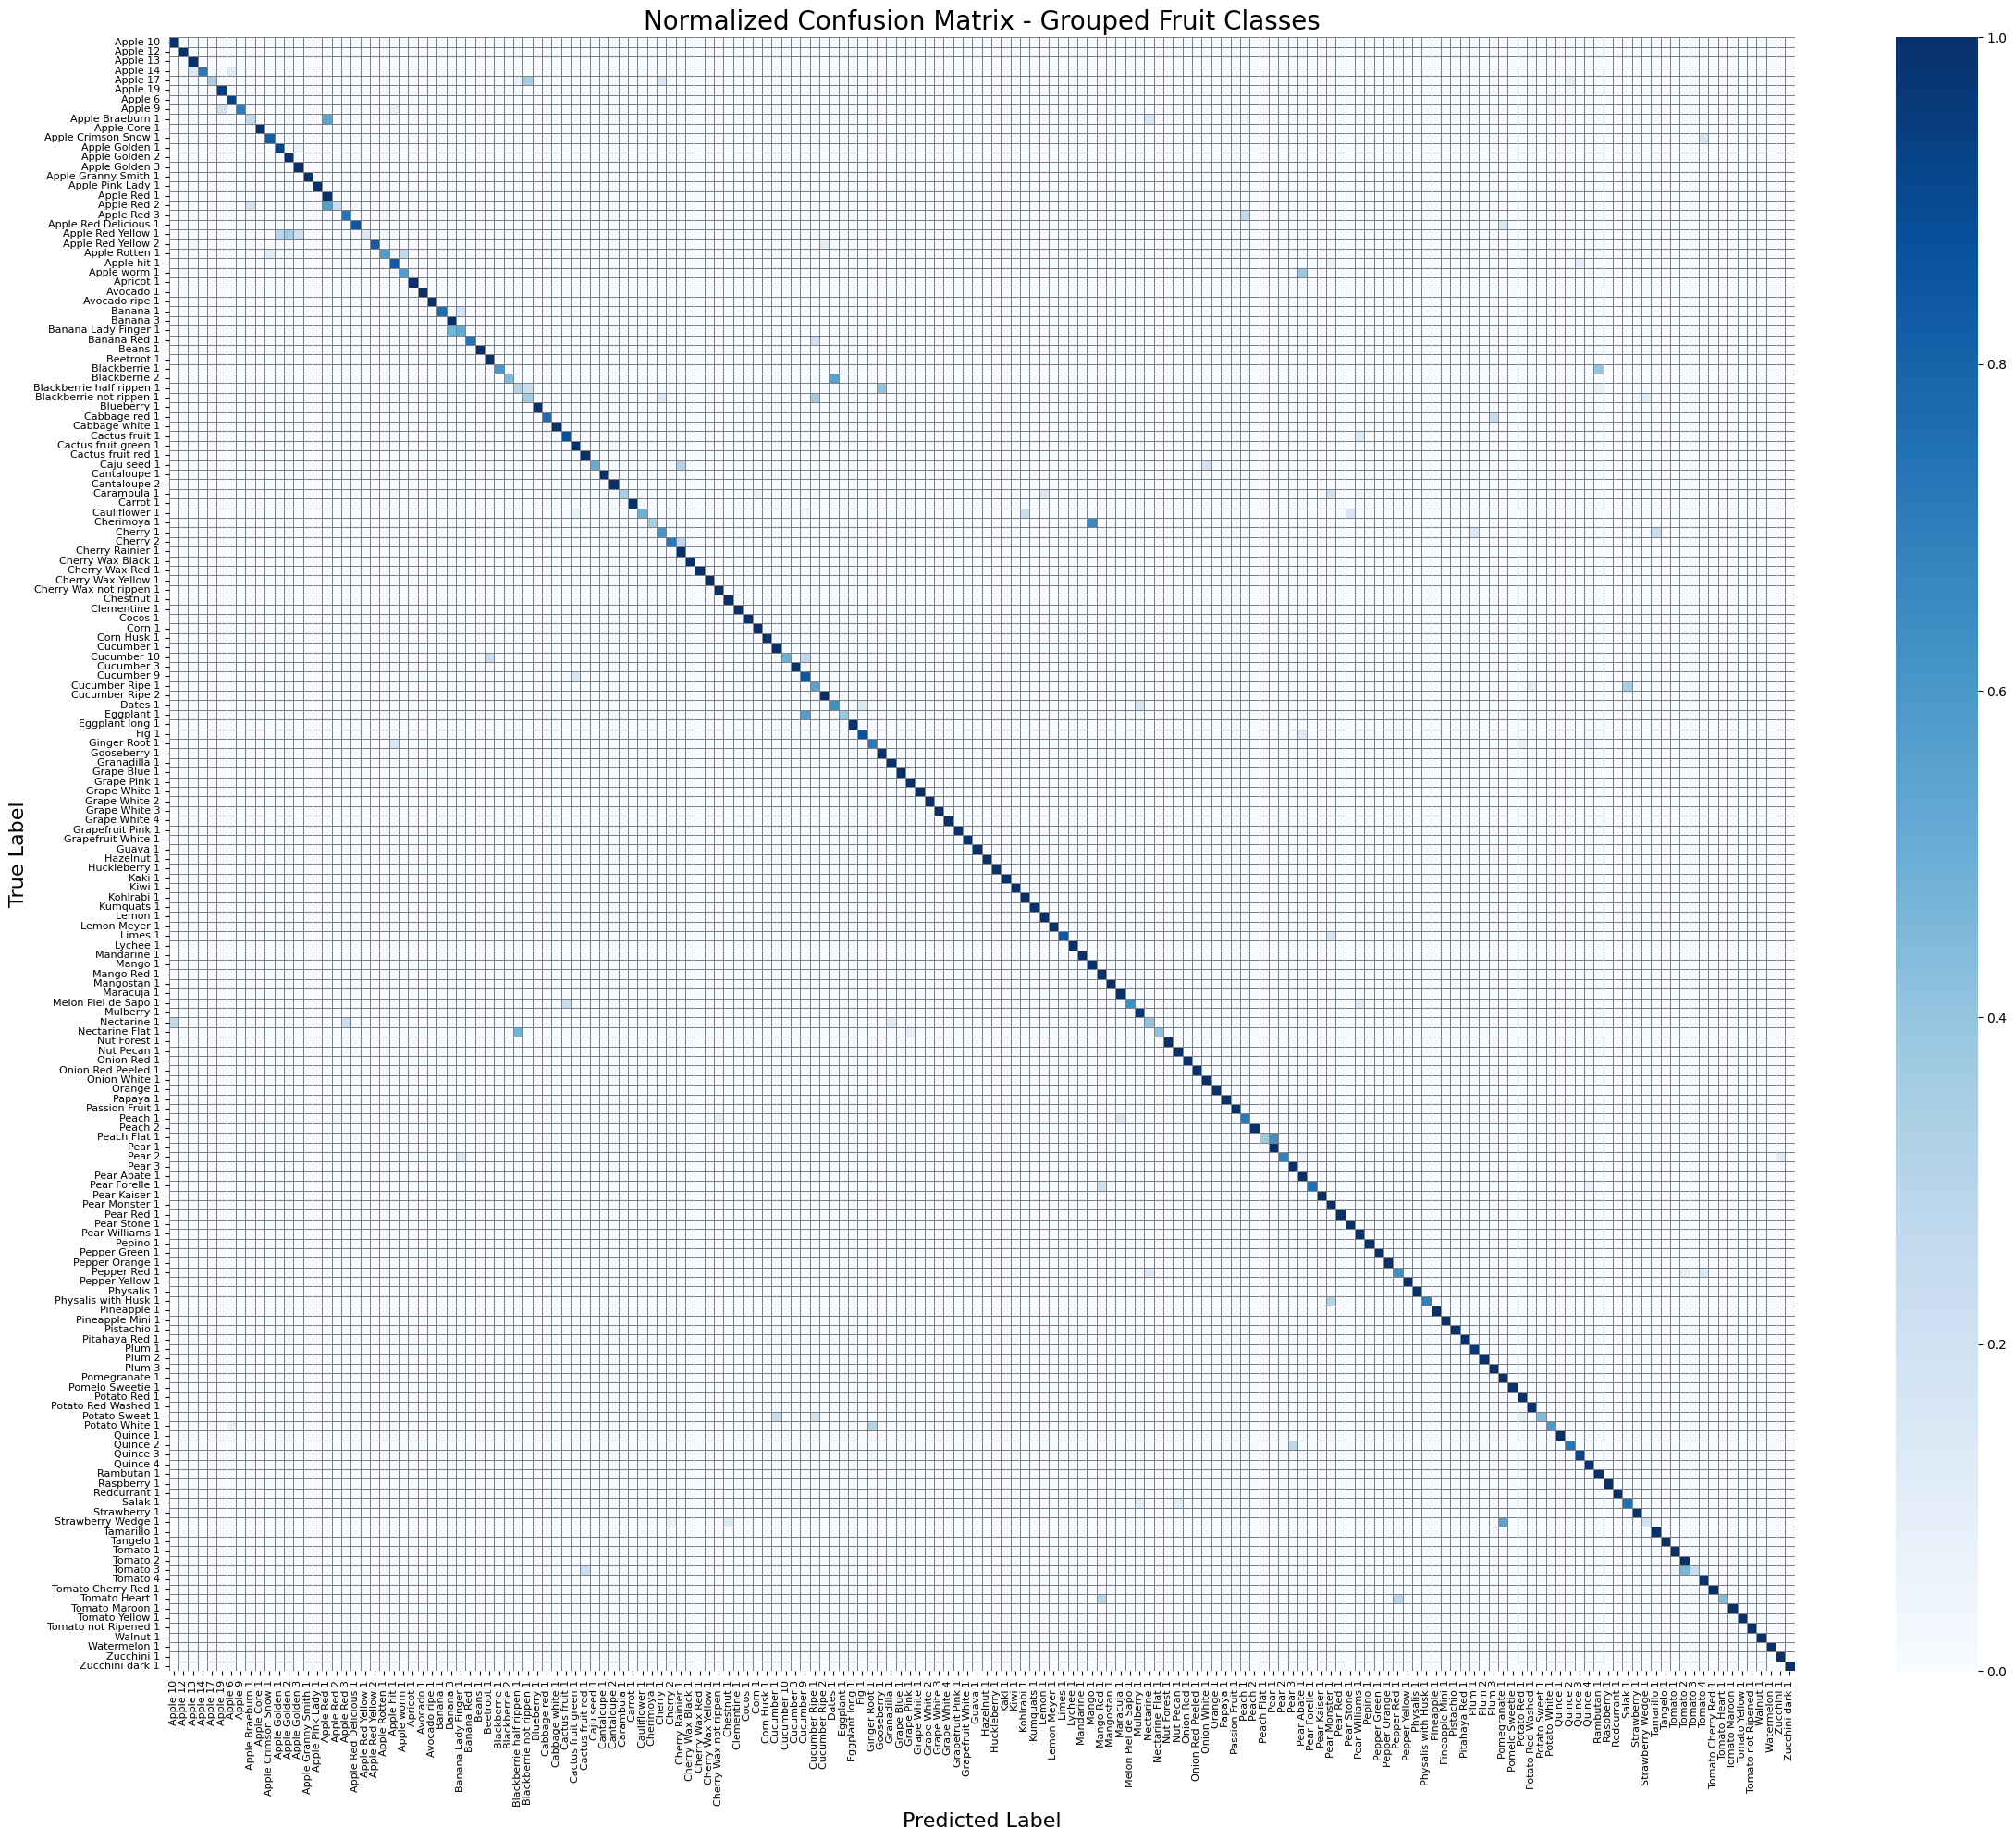

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import pickle

#  Load the trained model and PCA transformer 
model = load_model("fruit_model.h5")

with open("pca_transformer.pkl", "rb") as f:
    pca = pickle.load(f)

#  Set dataset path and image size ---
dataset_path = "fruits-360_100x100/fruits-360/Training"
img_size = (100, 100)

#  Reload validation data using ImageDataGenerator ---
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=32,
    subset="validation",
    class_mode="sparse",
    shuffle=False
)

#  Extract all validation data (images and labels) ---
X_val, y_val = [], []
for _ in range(len(val_gen)):
    x_batch, y_batch = next(val_gen)
    X_val.extend(x_batch)
    y_val.extend(y_batch)

X_val = np.array(X_val)
y_val = np.array(y_val).astype(int)

print("Validation data shape:", X_val.shape)

# Flatten and apply PCA ---
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_val_pca = pca.transform(X_val_flat)

# Predict using the model ---
y_pred_probs = model.predict(X_val_pca)
y_pred = np.argmax(y_pred_probs, axis=1)

# Map indices to class labels ---
index_to_class = {v: k for k, v in val_gen.class_indices.items()}
y_val_labels = [index_to_class[i] for i in y_val]
y_pred_labels = [index_to_class[i] for i in y_pred]

#  Generate confusion matrix ---
class_names = sorted(list(set(index_to_class.values())))
cm = confusion_matrix(y_val_labels, y_pred_labels, labels=class_names)

# Normalize confusion matrix, avoid division by zero
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True)
cm_percent = np.nan_to_num(cm_percent)  # Replace NaNs with 0

# Plot and save heatmap ---
plt.figure(figsize=(24, 20))
sns.heatmap(cm_percent, annot=False, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            linewidths=0.5, linecolor='gray')

plt.title("Normalized Confusion Matrix - Grouped Fruit Classes", fontsize=20)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()

plt.savefig("grouped_confusion_matrix_named.png", dpi=300)
plt.show()


Found 17261 images belonging to 170 classes.
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


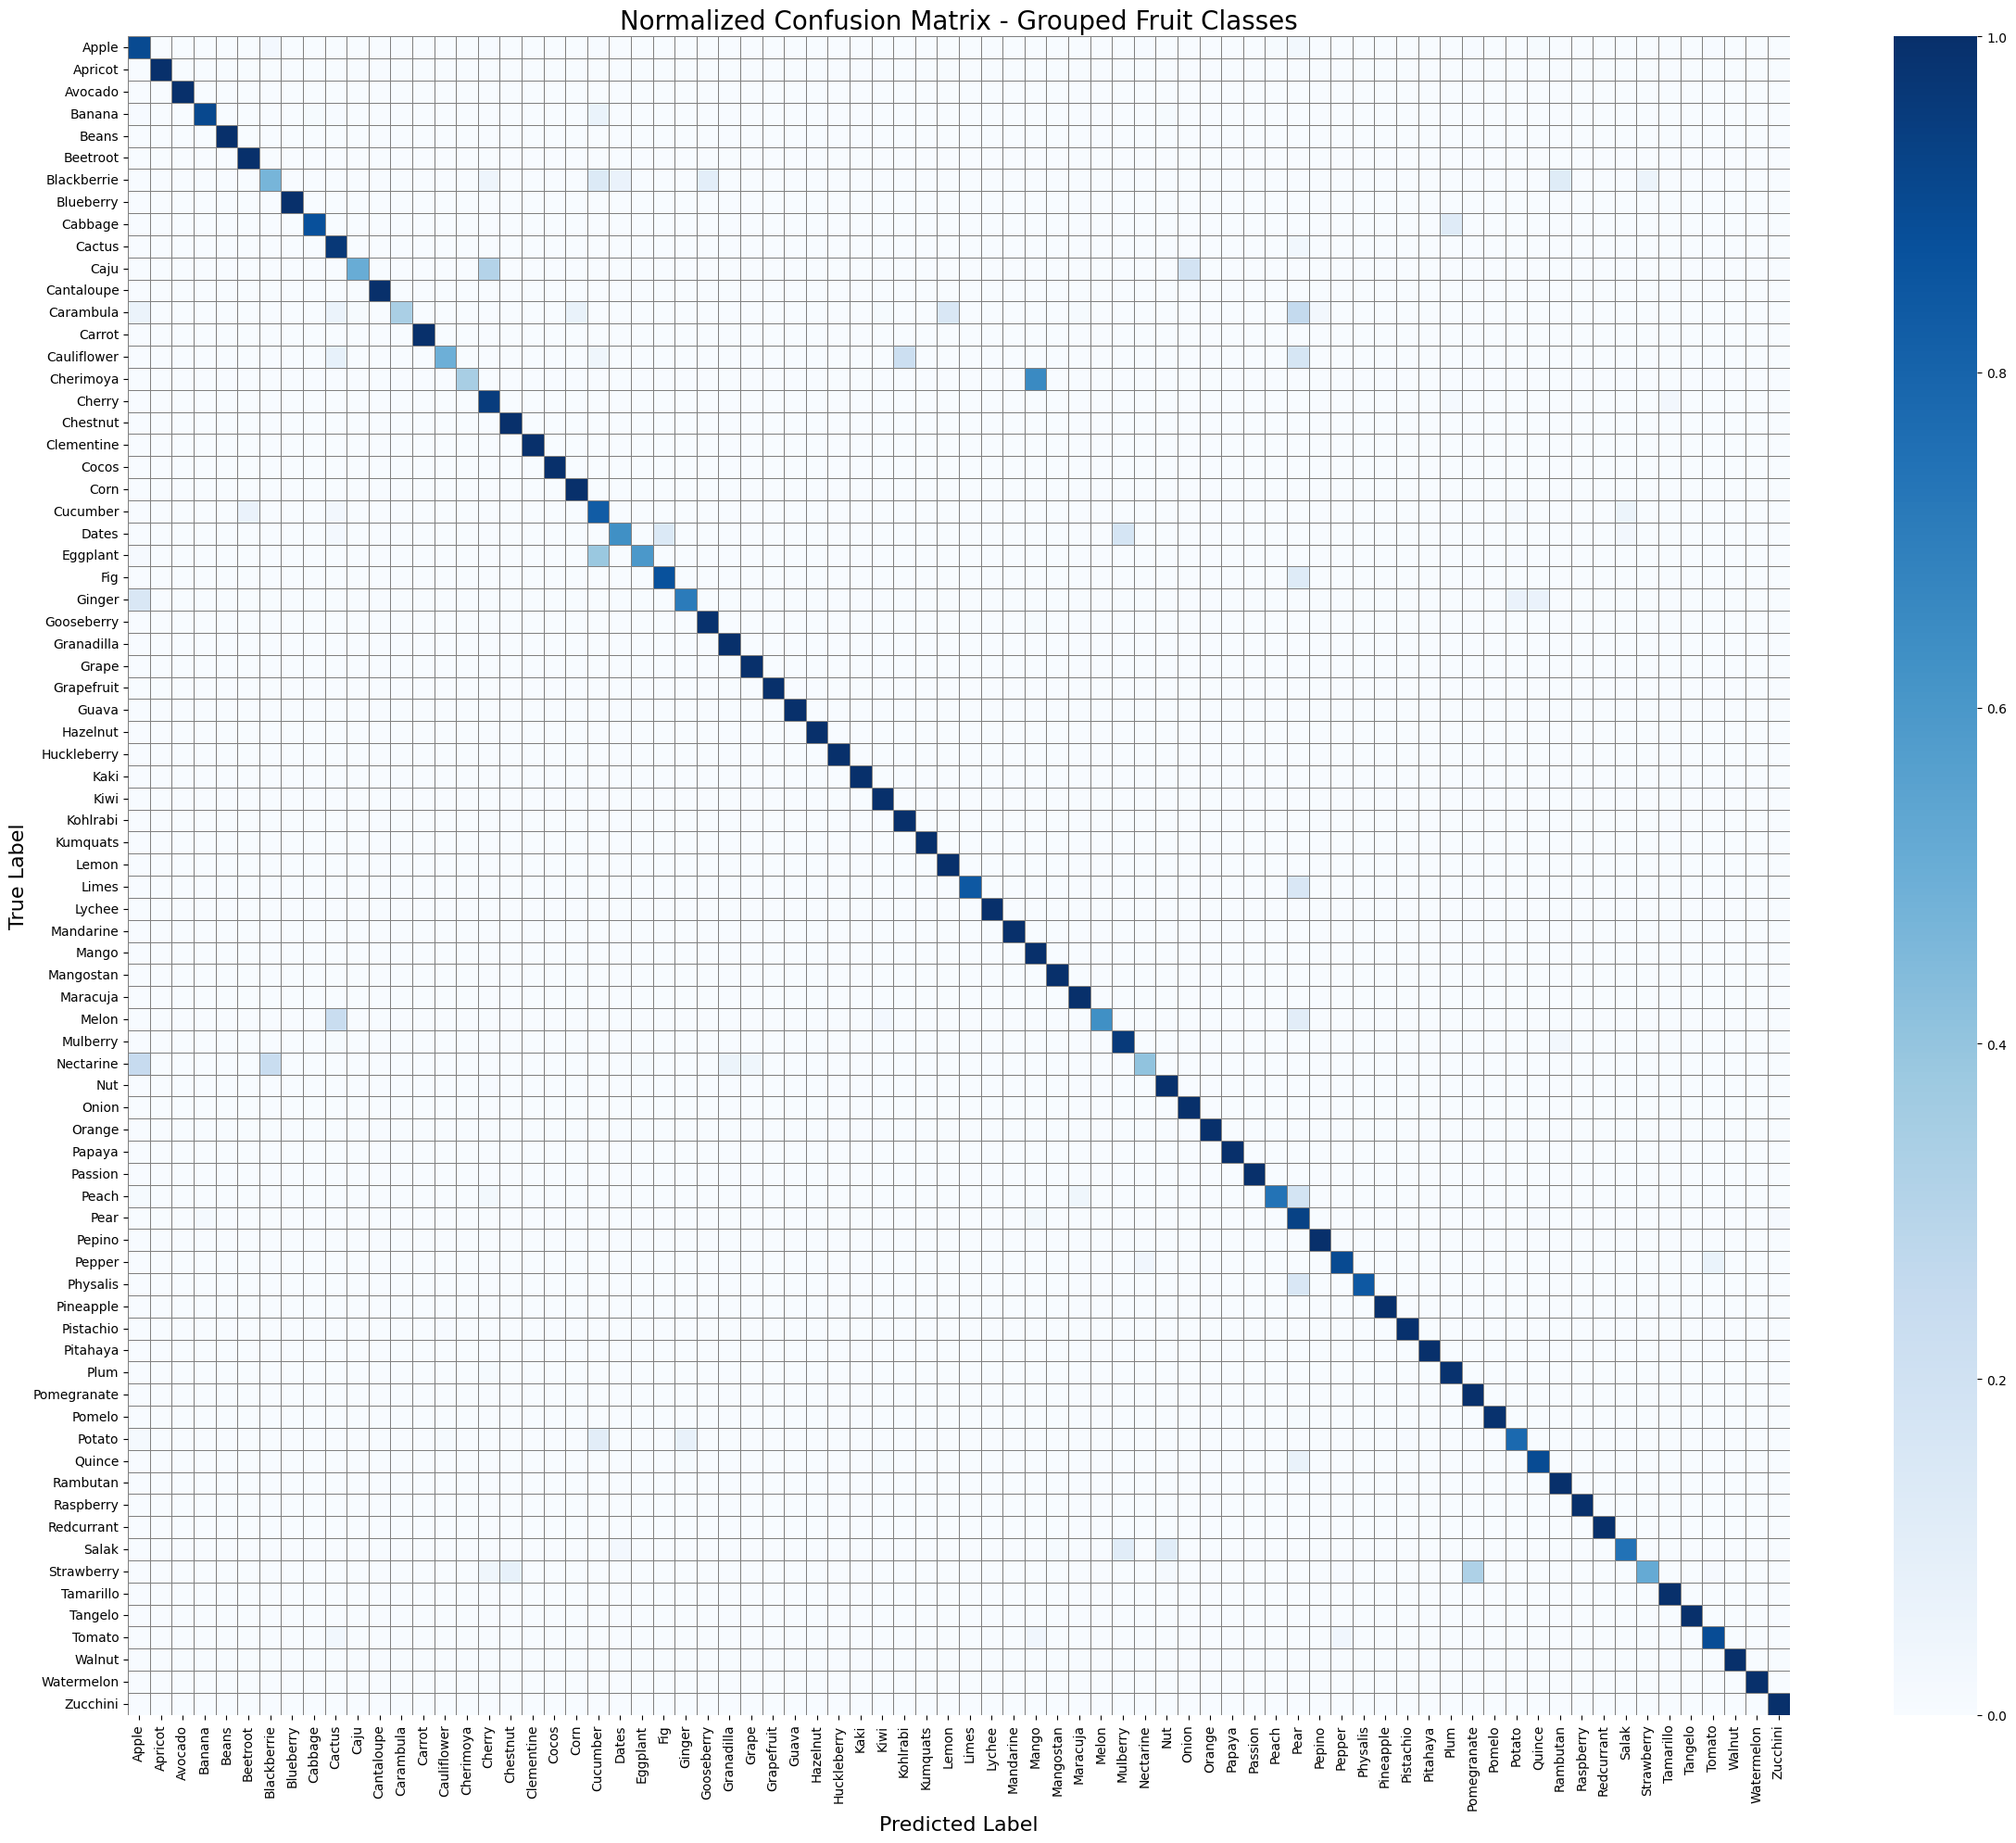

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#  Load trained model and PCA ---
model = load_model("fruit_model.h5")
with open("pca_transformer.pkl", "rb") as f:
    pca = pickle.load(f)

#  Paths and image settings ---
dataset_path = "fruits-360_100x100/fruits-360/Training"
img_size = (100, 100)

# Load validation data ---
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=32,
    subset="validation",
    class_mode="sparse",
    shuffle=False
)

# Collect all validation data 
X_val, y_val = [], []
for i in range(len(val_gen)):
    x_batch, y_batch = val_gen[i]
    X_val.extend(x_batch)
    y_val.extend(y_batch)
    if (i + 1) * val_gen.batch_size >= val_gen.samples:
        break

X_val = np.array(X_val)
y_val = np.array(y_val).astype(int)

#  Flatten and transform via PCA 
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_val_pca = pca.transform(X_val_flat)

# Predict
y_pred_probs = model.predict(X_val_pca)
y_pred_indices = np.argmax(y_pred_probs, axis=1)

# Map indices to class names 
index_to_class = {v: k for k, v in val_gen.class_indices.items()}
y_val_full = [index_to_class[i] for i in y_val]
y_pred_full = [index_to_class[i] for i in y_pred_indices]

#  Simplify class names (grouping by fruit type) 
def simplify_class(name):
    return name.split()[0]  # e.g. "Apple"

y_val_grouped = [simplify_class(name) for name in y_val_full]
y_pred_grouped = [simplify_class(name) for name in y_pred_full]

# Compute confusion matrix 
class_names = sorted(list(set(y_val_grouped) | set(y_pred_grouped)))
cm = confusion_matrix(y_val_grouped, y_pred_grouped, labels=class_names)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Plot confusion matrix 
plt.figure(figsize=(24, 20))
sns.heatmap(cm_percent, annot=False, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            linewidths=0.5, linecolor='gray')

plt.title("Normalized Confusion Matrix - Grouped Fruit Classes", fontsize=20)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.xticks(rotation=90, ha='center', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save and show 
plt.savefig("grouped_confusion_matrix_merged.png", dpi=300)
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#  Load and prepare validation data
val_data = np.loadtxt("fruit_pca_val.csv", delimiter=",", dtype=np.float32)
X_val = val_data[:, :-1]
y_val = val_data[:, -1].astype(int)

# Ensure X_val is a 2D float32 array
X_val = np.asarray(X_val, dtype=np.float32)
if X_val.ndim == 1:
    X_val = X_val.reshape(1, -1)

#  Load the model
model = tf.keras.models.load_model("fruit_model.h5")

#  Predict and calculate exact class match accuracy 
y_pred_probs = model.predict(X_val)
y_pred_indices = np.argmax(y_pred_probs, axis=1)

val_accuracy = accuracy_score(y_val, y_pred_indices)
print(f"\nValidation Accuracy (Exact Class Match): {val_accuracy * 100:.2f}%")


# Reload the validation data generator to get class names
dataset_path = "fruits-360_100x100/fruits-360/Training"
img_size = (100, 100)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=1,
    subset="validation",
    class_mode="sparse",
    shuffle=False
)

# Map class indices to names
index_to_class = {v: k for k, v in val_gen.class_indices.items()}

# Convert predicted and true labels to class names
y_val_full = [index_to_class[i] for i in y_val]
y_pred_full = [index_to_class[i] for i in y_pred_indices]

# Simplify to first word only (e.g., "Apple Red 1" -> "Apple")
def simplify_class(name):
    return name.split()[0]

y_val_grouped = [simplify_class(name) for name in y_val_full]
y_pred_grouped = [simplify_class(name) for name in y_pred_full]

# Compute grouped accuracy
grouped_accuracy = accuracy_score(y_val_grouped, y_pred_grouped)
print(f"Grouped Class Accuracy: {grouped_accuracy * 100:.2f}%")


540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Validation Accuracy (Exact Class Match): 85.79%
Found 17261 images belonging to 170 classes.
Grouped Class Accuracy: 89.21%


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Get predictions again
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert true labels to integer
y_true = y_val.astype(int)

# Calculate basic evaluation metrics
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print results
print(f"\nModel Evaluation Metrics:")
print(f"Accuracy  : {acc * 100:.2f}%")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")

# Print full classification report (per class)
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=[index_to_class[i] for i in sorted(index_to_class)]))


  1/540 ━━━━━━━━━━━━━━━━━━━━ 44s 82ms/step

540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Model Evaluation Metrics:
Accuracy  : 85.79%
Precision : 0.8873
Recall    : 0.8579
F1 Score  : 0.8483

Detailed Classification Report:
                           precision    recall  f1-score   support

                 Apple 10       0.84      1.00      0.91       139
                 Apple 12       0.94      1.00      0.97        93
                 Apple 13       0.87      1.00      0.93       139
                 Apple 14       1.00      0.72      0.84        93
                 Apple 17       1.00      0.34      0.50       122
                 Apple 19       0.82      0.94      0.88       145
                  Apple 6       0.82      0.94      0.88        94
                  Apple 9       1.00      0.70      0.83       138
         Apple Braeburn 1       0.58      0.27      0.36        98
             Apple Core 1       0.96      1.00      0.98        47
     Apple Crimson Snow 1       0.87      0.83      0.85        88
           Apple G